In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from proj.data.load import load_ibkr_prices, load_macro_series
from proj.data.reshaping import *
from proj.utils.dates import duration_to_dates

In [74]:
import asyncio
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.diagnostic import het_arch

In [75]:

plt.style.use("../styler.mplstyle") 

In [76]:
DURATION = "10 Y"        # hyperparameter
END_DATE = None 

START_DATE, END_DATE = duration_to_dates(DURATION, end=END_DATE)
START_DATE, END_DATE

(datetime.date(2015, 12, 4), datetime.date(2025, 12, 4))

## 1 ETF and Inverse ETF

In [77]:
etfs = [
    # etfs
    'SPY',
    'IWM',
    'QQQ',

    # inverses 
    'SH',
    'SPXU',

    #stocks 
    'PLTR'
    ]

In [78]:
df = await load_ibkr_prices(etfs, duration='3 M')

Connected to Interactive Brokers successfully.


In [79]:
df

,date,Symbol,open,high,low,close,volume
0,2025-09-08,SPY,648.62,649.84,647.23,648.83,40875169.0
1,2025-09-09,SPY,648.96,650.86,647.22,650.33,39500904.0
2,2025-09-10,SPY,653.63,654.55,650.63,652.21,49284205.0
3,2025-09-11,SPY,654.18,658.33,653.59,657.63,45479139.0
4,2025-09-12,SPY,657.59,659.11,656.90,657.41,47619613.0
...,...,...,...,...,...,...,...
377,2025-11-28,PLTR,167.76,168.80,165.87,168.45,10917639.0
378,2025-12-01,PLTR,165.00,169.10,163.12,167.49,18901844.0
379,2025-12-02,PLTR,169.59,175.75,169.59,170.69,24388994.0
380,2025-12-03,PLTR,170.14,177.91,168.83,176.08,20807371.0


In [80]:
pivoted = long_to_wide(df).dropna().set_index('date')

In [81]:
returns = pivoted.pct_change().dropna()
returns.head()

,IWM,PLTR,QQQ,SH,SPXU,SPY
date,,,,,,
2025-09-09,-0.005876,0.040102,0.002833,-0.002349,-0.006069,0.002312
2025-09-10,-0.001773,0.026977,0.000327,-0.002616,-0.008820,0.002891
2025-09-11,0.018483,-0.014274,0.005821,-0.007608,-0.023956,0.008310
2025-09-12,-0.010216,0.043015,0.004417,0.000529,0.001403,-0.000335
2025-09-15,0.004238,-0.001283,0.008557,-0.005020,-0.014706,0.005324


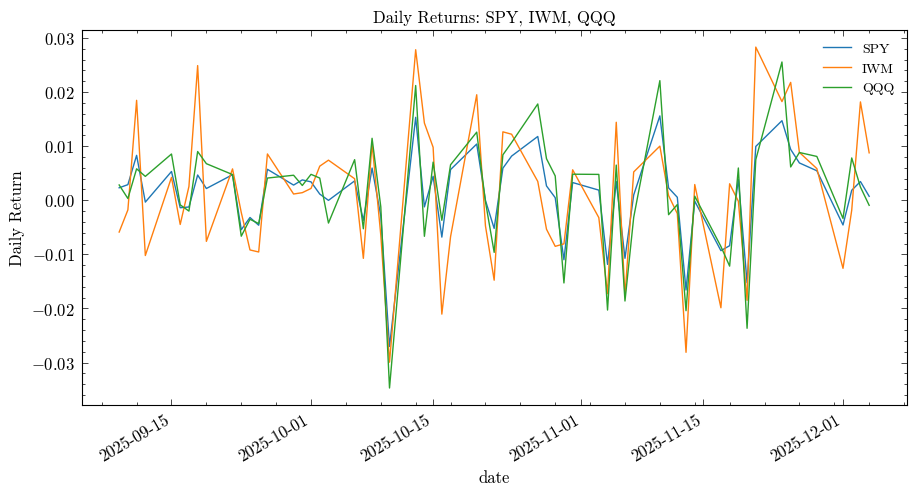

In [82]:
returns[["SPY", "IWM", "QQQ"]].plot(figsize=(10,5))
plt.title("Daily Returns: SPY, IWM, QQQ")
plt.ylabel("Daily Return")

plt.savefig(f'../Figures/Assignment09/etf.png', dpi = 300)
plt.show()

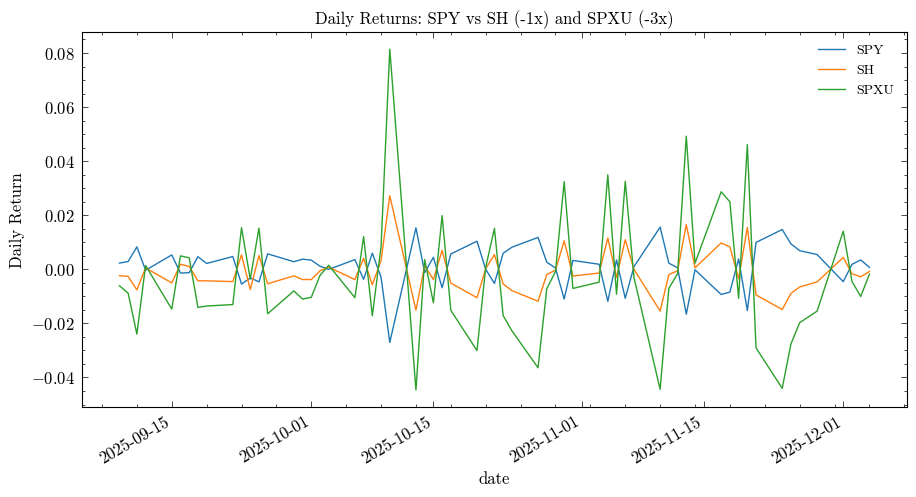

In [83]:
returns[["SPY", "SH", "SPXU"]].plot(figsize=(10,5))
plt.title("Daily Returns: SPY vs SH (-1x) and SPXU (-3x)")
plt.ylabel("Daily Return")

plt.savefig(f'../Figures/Assignment09/inv_etf.png', dpi = 300)
plt.show()



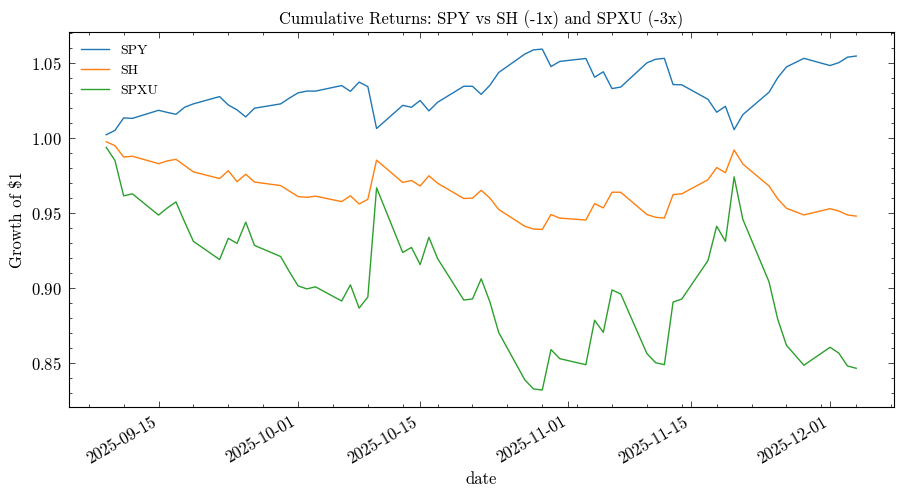

In [84]:
cumulative = (1 + returns).cumprod()

cumulative[["SPY", "SH", "SPXU"]].plot(figsize=(10,5))
plt.title("Cumulative Returns: SPY vs SH (-1x) and SPXU (-3x)")
plt.ylabel("Growth of $1")
plt.savefig(f'../Figures/Assignment09/cumultive.png', dpi = 300)
plt.show()

In [85]:
pivoted

,IWM,PLTR,QQQ,SH,SPXU,SPY
date,,,,,,
2025-09-08,238.25,156.10,578.87,38.31,59.32,648.83
2025-09-09,236.85,162.36,580.51,38.22,58.96,650.33
2025-09-10,236.43,166.74,580.70,38.12,58.44,652.21
2025-09-11,240.80,164.36,584.08,37.83,57.04,657.63
2025-09-12,238.34,171.43,586.66,37.85,57.12,657.41
...,...,...,...,...,...,...
2025-11-28,248.75,168.45,619.25,36.35,50.34,683.39
2025-12-01,245.62,167.49,617.17,36.51,51.05,680.27
2025-12-02,245.17,170.69,622.00,36.45,50.82,681.53


## 2 Simulated Short

last 30 days

In [175]:
days = 30
short_df = pivoted[-30:]

In [176]:
short_amount = 100_000
borrow_rate = .05390 


In [188]:
entry_date = short_df.index[0]

entry_price_pltr = short_df.loc[entry_date, "PLTR"]
entry_price_spy  = short_df.loc[entry_date, "SPY"]

shares_pltr = short_amount / entry_price_pltr    
shares_spy  = short_amount / entry_price_spy

In [189]:
print(shares_pltr, shares_spy)

554.0780141843971 148.8626890556151


In [190]:
entry_price_pltr

np.float64(180.48)

In [191]:
pnl_pltr = shares_pltr * (entry_price_pltr - short_df["PLTR"])
pnl_spy  = shares_spy  * (entry_price_spy  - short_df["SPY"])

In [193]:
borrow_cost_pltr = short_amount * borrow_rate * ( np.arange(days) / 360)
borrow_cost_spy  = short_amount  * borrow_rate  * ( np.arange(days) / 360)

In [194]:
net_pltr = pnl_pltr - borrow_cost_pltr
net_spy  = pnl_spy  - borrow_cost_spy

In [195]:
result = pd.DataFrame({
    "PLTR_Price": short_df["PLTR"],
    "SPY_Price": short_df["SPY"],
    'borrow_rate': borrow_cost_pltr, 
    "Pnl_PLTR": pnl_pltr,
    "Pnl_SPY": pnl_spy,
    "Net_PLTR": net_pltr,
    "Net_SPY": net_spy,
})

result.head()

,PLTR_Price,SPY_Price,borrow_rate,Pnl_PLTR,Pnl_SPY,Net_PLTR,Net_SPY
date,,,,,,,
2025-10-23,180.48,671.76,0.000000,0.000000,0.000000,0.000000,0.000000
2025-10-24,184.63,677.25,14.972222,-2299.423759,-817.256163,-2314.395981,-832.228385
2025-10-27,189.18,685.24,29.944444,-4820.478723,-2006.669048,-4850.423168,-2036.613493
2025-10-28,189.60,687.06,44.916667,-5053.191489,-2277.599143,-5098.108156,-2322.515809
2025-10-29,198.81,687.39,59.888889,-10156.250000,-2326.723830,-10216.138889,-2386.612719


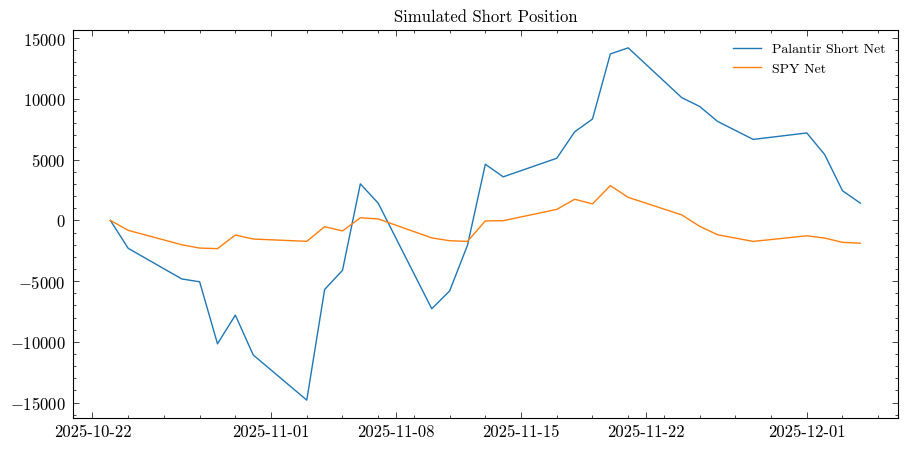

In [208]:
plt.figure(figsize=(10, 5))
plt.title("Simulated Short Position")
plt.plot(result['Pnl_PLTR'], label = 'Palantir Short Net')
plt.plot(result['Pnl_SPY'], label = 'SPY Net')
plt.savefig(f'../Figures/Assignment09/simulated_short.png', dpi = 300)
plt.legend()